# FloPy
### UZF example
Demonstrates functionality of the flopy UZF module using the example from [Niswonger and others (2006)](http://pubs.usgs.gov/tm/2006/tm6a19/). This is the same as the SFR example problem from Prudic and others (2004;
p. 13–19), except the UZF package replaces the ET and RCH packages.

#### Problem description:

* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 12  
* Units are in seconds and days
* Flow package: LPF  
* Stress packages: SFR, GHB, UZF 
* Solver: SIP  

<img src="./img/Niswonger2006_fig13.png" width="400" height="500"/>

In [1]:
%matplotlib inline

import sys
import glob
import os
import platform
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

In [2]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name += '.exe'

In [3]:
path = 'temp'
if not os.path.isdir(path):
    os.mkdirs(path)
gpth = os.path.join('..', 'data', 'mf2005_test', 'UZFtest2.*')
for f in glob.glob(gpth):
    shutil.copy(f, path)

### Load example dataset, skipping the UZF package

In [4]:
m = flopy.modflow.Modflow.load('UZFtest2.nam', version='mf2005', exe_name=exe_name, 
                               model_ws=path, load_only=['ghb', 'dis', 'bas6', 'oc', 'sip', 'lpf', 'sfr'])

### remove previous uzf external file references 
(so they don't conflict with the ones made by flopy)

In [5]:
m.external_fnames

['temp/UZFtest2.uzf1',
 'temp/UZFtest2.uzf2',
 'temp/UZFtest2.uzf3',
 'temp/UZFtest2.uzf4',
 'temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9',
 'temp/UZFtest2.sg1',
 'temp/UZFtest2.uzfot']

In [6]:
rm = [True if '.uz' in f else False for f in m.external_fnames]

In [7]:
m.external_fnames = [f for i, f in enumerate(m.external_fnames) if not rm[i]]
m.external_fnames

['temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9',
 'temp/UZFtest2.sg1']

In [8]:
m.external_binflag = [f for i, f in enumerate(m.external_binflag) if not rm[i]]
m.external_output = [f for i, f in enumerate(m.external_output) if not rm[i]]
m.external_units = [f for i, f in enumerate(m.external_output) if not rm[i]]

### `izufbnd` array  
* in the example, the UZF package **izufbnd** array is the same as the ibound

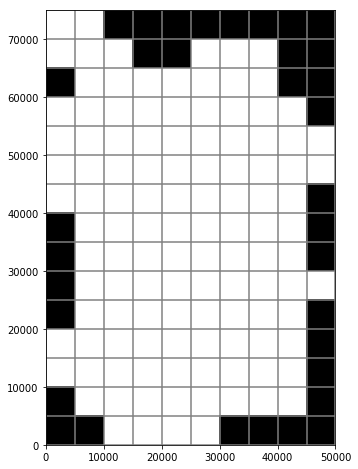

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()

### Set up the ```irunbnd``` array  
* read this in from an external file

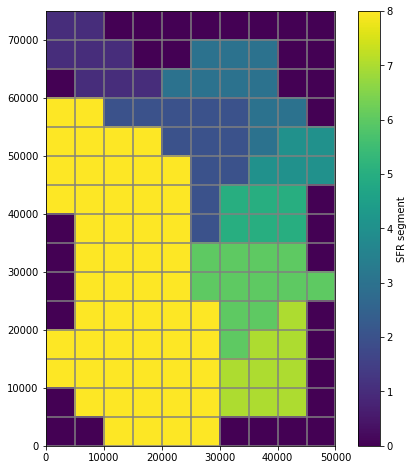

In [10]:
irnbndpth = os.path.join('..', 'data', 'uzf_examples', 'irunbnd.dat')
irunbnd = np.loadtxt(irnbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
irunbndplt = modelmap.plot_array(irunbnd)
plt.colorbar(irunbndplt, ax=ax, label='SFR segment')
linecollection = modelmap.plot_grid()

### ``vks`` (unsaturated zone vertical hydraulic conductivity) array

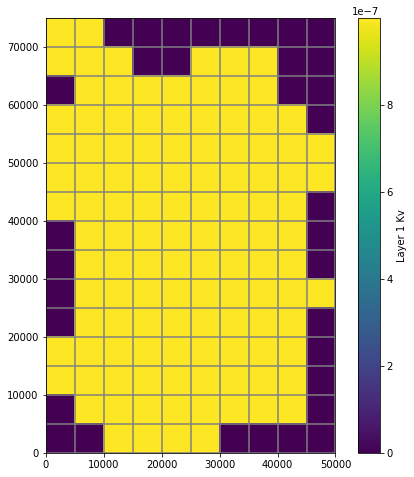

In [11]:
vksbndpth = os.path.join('..', 'data', 'uzf_examples', 'vks.dat')
vks = np.loadtxt(vksbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
vksplt = modelmap.plot_array(vks)
plt.colorbar(vksplt, ax=ax, label='Layer 1 Kv')
linecollection = modelmap.plot_grid()

In [12]:
m2 = flopy.modflow.Modflow.load('UZFtest2.nam', version='mf2005', exe_name='mf2005', 
                               model_ws=path)

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
   loading pet array...
   loading extdp array...
   loading extwc array...
stress period 2:
   loading finf array...
   loading pet array...
stress period 3:
   loading finf array...
stress period 4:
   loading finf array...
stress period 5:
   loading finf array...
stress period 6:
   loading finf array...
stress period 7:
   loading finf array...
stress period 8:
   loading finf array...
stress period 9:
   loading finf array...
stress period 10:
   loading finf array...
stress period 11:
   loading finf array...
stress period 12:
   loading finf array...


### `finf` array  
* load infiltration rates from a file into a 3D array
* `finf` can be submitted to FloPy as a 3D array, list of 2D arrays, list of numeric values, or single numeric value

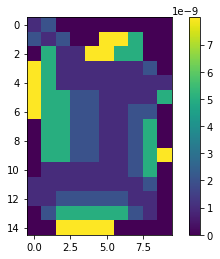

In [13]:
finf = np.loadtxt(os.path.join('..', 'data', 'uzf_examples', 'finf.dat'))
finf = np.reshape(finf, (m2.nper, m2.nrow, m2.ncol))
plt.imshow(finf[0], interpolation='none')
plt.colorbar()

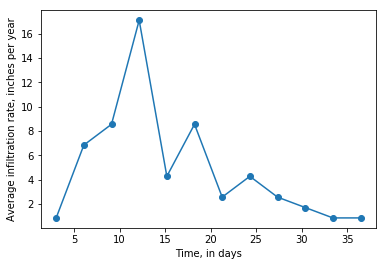

In [14]:
plt.plot(m2.dis.perlen.array.cumsum()/864600, 
         [a.mean() * 86400 * 365 * 12 for a in finf[:, :, :]], marker='o')
plt.xlabel('Time, in days')
plt.ylabel('Average infiltration rate, inches per year')

### `extwc` (extinction water content) array

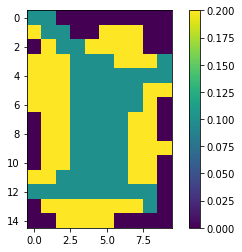

In [15]:
extwc = np.loadtxt(os.path.join('..', 'data', 'uzf_examples', 'extwc.dat'))
plt.imshow(extwc, interpolation='none')
plt.colorbar()

### Set up the gages (observation points)
* supplied as a dictionary keyed by `IFTUNIT`
* A positive value [of `IFTUNIT`] is for output of individual cells whereas a negative value is for output that is summed over all model cells. 
* values are a list of `[IUZROW, IUZCOL, IFTUNIT, IUZOPT]`
* `IUZROW` and `IUZCOL` are zero based

In [16]:
uzgag = {-68: [-68],
         65: [2, 5, 65, 1], #Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
         66: [5, 2, 66, 2], #Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
         67: [9, 4, 67, 3]} #Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone. 

### Make the UZF package

In [17]:
uzf = flopy.modflow.ModflowUzf1(m,
                                nuztop=1, iuzfopt=1, irunflg=1, ietflg=1,
                                ipakcb=0, 
                                iuzfcb2=61,# binary output of recharge and groundwater discharge
                                ntrail2=25, nsets=20, nuzgag=4,
                                surfdep=1.0, uzgag=uzgag,
                                iuzfbnd=m2.bas6.ibound.array, 
                                irunbnd=irunbnd, 
                                vks=vks, # saturated vertical hydraulic conductivity of the uz
                                finf=finf, #infiltration rates
                                eps=3.5, # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
                                thts = 0.35, # saturated water content of the uz in units of volume of water to total volume
                                pet=5.000000E-08, # potential ET
                                extdp=15., # ET extinction depth(s)
                                extwc=extwc, #extinction water content below which ET cannot be removed from the unsaturated zone
                                unitnumber=19)

In [18]:
m.write_input()

### run the model

In [19]:
m.run_model()

FloPy is using the following executable to run the model: /Users/jdhughes/Documents/Development/bin/mac/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: UZFtest2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/03/15 12:25:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2  

(True, [])

## Results

### Look at the budget output

In [20]:
uzfbdobjct = bf.CellBudgetFile(os.path.join(path,'UZFtest2.uzfcb2.bin'))
uzfbdobjct.list_records()

(1, 1, b'           GW ET', 10, 15, -1, 4, 2628000.0, 2628000.0, 2628000.0, b'', b'', b'', b'')
(1, 1, b'    UZF RECHARGE', 10, 15, -1, 4, 2628000.0, 2628000.0, 2628000.0, b'', b'', b'', b'')
(1, 1, b' SURFACE LEAKAGE', 10, 15, -1, 4, 2628000.0, 2628000.0, 2628000.0, b'', b'', b'', b'')
(1, 1, b'       HORT+DUNN', 10, 15, -1, 4, 2628000.0, 2628000.0, 2628000.0, b'', b'', b'', b'')
(1, 1, b'  STORAGE CHANGE', 10, 15, -1, 4, 2628000.0, 2628000.0, 2628000.0, b'', b'', b'', b'')
(1, 2, b'           GW ET', 10, 15, -1, 4, 82713.0703125, 82713.0703125, 2710713.0, b'', b'', b'', b'')
(1, 2, b'    UZF RECHARGE', 10, 15, -1, 4, 82713.0703125, 82713.0703125, 2710713.0, b'', b'', b'', b'')
(1, 2, b' SURFACE LEAKAGE', 10, 15, -1, 4, 82713.0703125, 82713.0703125, 2710713.0, b'', b'', b'', b'')
(1, 2, b'       HORT+DUNN', 10, 15, -1, 4, 82713.0703125, 82713.0703125, 2710713.0, b'', b'', b'', b'')
(1, 2, b'  STORAGE CHANGE', 10, 15, -1, 4, 82713.0703125, 82713.0703125, 2710713.0, b'', b'', b'', b'')


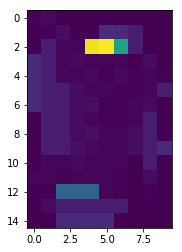

In [21]:
r = uzfbdobjct.get_data(text='UZF RECHARGE')
et = uzfbdobjct.get_data(text='GW ET')
plt.imshow(r[6], interpolation='None')

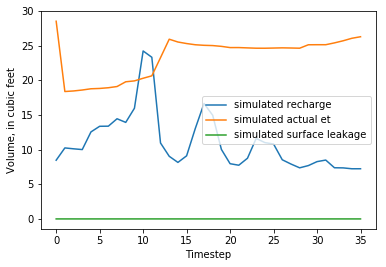

In [22]:
rtot = [rp.sum() for rp in r]
ettot = [etp.sum() for etp in et]
sltot = [sl.sum() for sl in uzfbdobjct.get_data(text='SURFACE LEAKAGE')]

plt.plot(rtot, label='simulated recharge')
plt.plot(np.abs(ettot), label='simulated actual et')
plt.plot(np.abs(sltot), label='simulated surface leakage')
plt.xlabel('Timestep')
plt.ylabel('Volume, in cubic feet')
plt.legend()

### Look at the gages

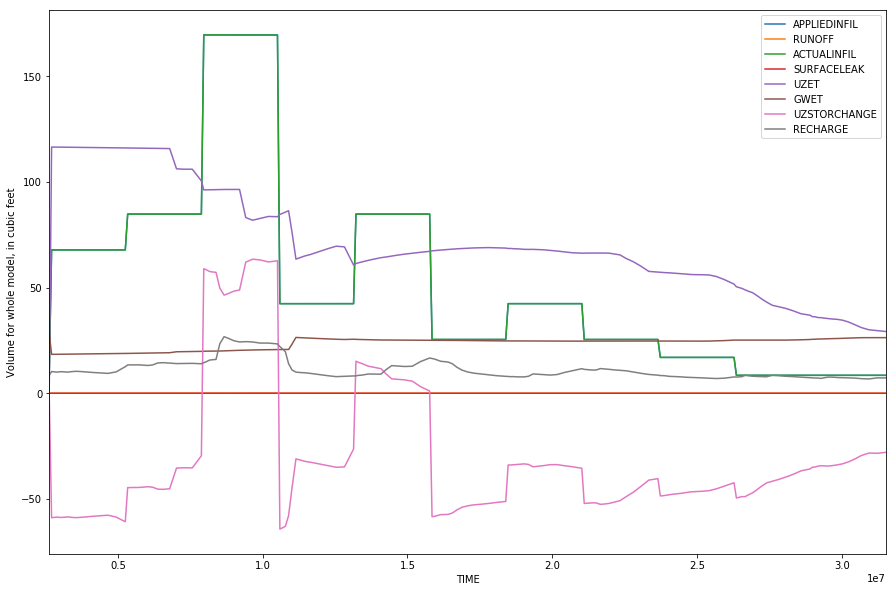

In [23]:
fpth = os.path.join(path, 'UZFtest2.uzf68.out')
dtype = [('TIME', np.float), ('APPLIED-INFIL', np.float), ('RUNOFF', np.float), 
         ('ACTUAL-INFIL', np.float), ('SURFACE-LEAK', np.float), 
         ('UZ-ET', np.float), ('GW-ET', np.float), ('UZSTOR-CHANGE', np.float), 
         ('RECHARGE', np.float)]
# read data from file
df = np.genfromtxt(fpth, skip_header=3, dtype=dtype)
# convert numpy recarray to pandas dataframe
df = pd.DataFrame(data=df)
# set index to the time column
df.set_index(['TIME'], inplace=True)
# plot the data
ax = df.plot(legend=False, figsize=(15, 10))
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=1)
ax.set_ylabel('Volume for whole model, in cubic feet')

### Plot water content profile through time at row 10, column 5

In [24]:
fpth = os.path.join(path, 'UZFtest2.uzf67.out')
data = []
with open(fpth) as input:
    for i in range(3):
        next(input)
    for line in input:
        line = line.strip().split()
        if len(line) == 6:
            layer = int(line.pop(0))
            time = float(line.pop(0))
            head = float(line.pop(0))
            uzthick = float(line.pop(0))
        depth = float(line.pop(0))
        watercontent = float(line.pop(0))
        data.append([layer, time, head, uzthick, depth, watercontent])

In [25]:
df3 = pd.DataFrame(data, columns=['layer', 'time', 'head', 'uzthick', 'depth', 'watercontent'])
df3.head(41)

,layer,time,head,uzthick,depth,watercontent
0,1,2628000.0,1036.0872,9.412842,0.235315,0.183876
1,1,2628000.0,1036.0872,9.412842,0.470630,0.183876
2,1,2628000.0,1036.0872,9.412842,0.705945,0.183876
3,1,2628000.0,1036.0872,9.412842,0.941261,0.183876
4,1,2628000.0,1036.0872,9.412842,1.176576,0.183876
5,1,2628000.0,1036.0872,9.412842,1.411891,0.183876
6,1,2628000.0,1036.0872,9.412842,1.647206,0.183876
7,1,2628000.0,1036.0872,9.412842,1.882521,0.183876
8,1,2628000.0,1036.0872,9.412842,2.117837,0.183876
9,1,2628000.0,1036.0872,9.412842,2.353152,0.183876


In [26]:
wc = df3.watercontent.reshape(len(df3.time.unique()), 40).T
wc = pd.DataFrame(wc, columns=df3.time.unique(), index=df3.depth[0:40])
wc.head()

/Users/jdhughes/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


,2628000.0,2710713.0,2801697.5,2901780.2,3011871.2,3132971.5,3266181.8,3412713.0,3573897.5,3751200.2,...,29546176.0,29692708.0,29853892.0,30031194.0,30226228.0,30440764.0,30676754.0,30936344.0,31221892.0,31535994.0
depth,,,,,,,,,,,,,,,,,,,,,
0.235315,0.183876,0.188524,0.193666,0.199354,0.205651,0.210728,0.210716,0.210684,0.210643,0.210704,...,0.181644,0.181634,0.181620,0.181621,0.181623,0.181614,0.181609,0.181621,0.181646,0.181642
0.470630,0.183876,0.183601,0.183297,0.182964,0.182597,0.184087,0.191378,0.199477,0.208463,0.209815,...,0.176178,0.176156,0.176155,0.176150,0.176148,0.176159,0.176173,0.176164,0.176134,0.176139
0.705945,0.183876,0.183601,0.183297,0.182964,0.182597,0.182193,0.181749,0.181261,0.180723,0.188662,...,0.175859,0.175033,0.174181,0.173325,0.172464,0.171601,0.170738,0.169901,0.169081,0.168261
0.941261,0.183876,0.183601,0.183297,0.182964,0.182597,0.182193,0.181749,0.181261,0.180723,0.180132,...,0.178985,0.178566,0.178013,0.177326,0.176488,0.175481,0.174330,0.173105,0.171818,0.170466
1.176576,0.183876,0.183601,0.183297,0.182964,0.182597,0.182193,0.181749,0.181261,0.180723,0.180132,...,0.173670,0.173479,0.173315,0.173164,0.173025,0.172914,0.172784,0.172535,0.172140,0.171566


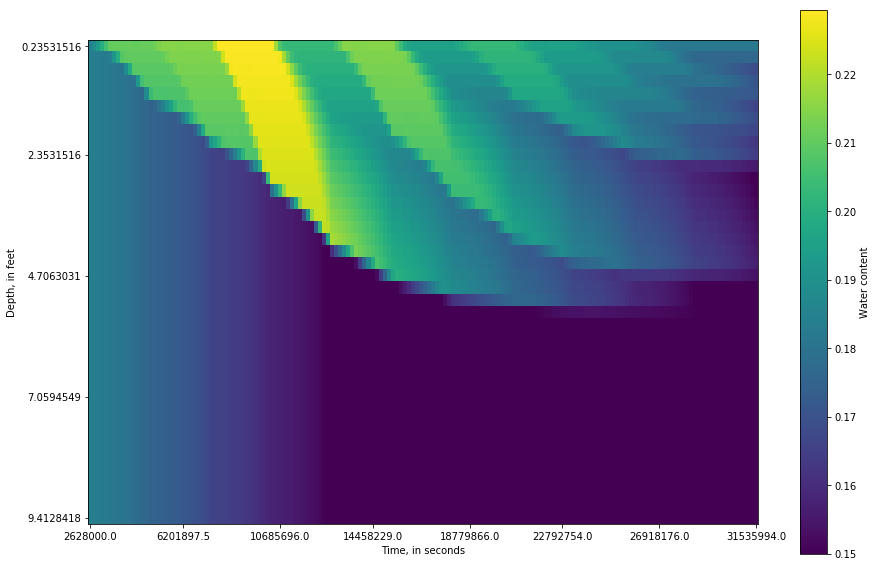

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wc, interpolation='None')
ax.set_aspect(3)
r, c = wc.shape
xcol_locs = np.linspace(0, c-1, 8, dtype=int)
ycol_locs = np.linspace(0, r-1, 5, dtype=int)
ax.set_xticks(xcol_locs)

xlabels = wc.columns
ax.set_xticklabels(xlabels[xcol_locs])
ax.set_ylabel('Depth, in feet')
ax.set_yticks(ycol_locs)
ax.set_yticklabels(wc.index[ycol_locs])
ax.set_xlabel('Time, in seconds')
plt.colorbar(label='Water content')